<a href="https://colab.research.google.com/github/Thamannahafeez/github-slideshow/blob/master/Rice_Leaf_Disease_using_IMGr_flowfromdirectory().ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical


In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
DATADIR = "/content/drive/MyDrive/Colab_Notebooks/Rice-Leaf/Rice_Leaf_Disease"

class_names = ["Bacterial leaf blight", "Brown spot","Leaf smut"]


In [ ]:
os.listdir(DATADIR)

['Brown spot', 'Bacterial leaf blight', 'Leaf smut']

In [ ]:
my_directory=image_dataset_from_directory(DATADIR,
                            labels='inferred',
                            label_mode='int',
                            class_names=class_names,
                            color_mode='rgb',
                            image_size=(200,200),
                            shuffle = True ,
                            seed = 100,
                            
                            )

Found 119 files belonging to 3 classes.


In [ ]:
#tf.data.Dataset
data =list(my_directory.file_paths)
len(data)

119

# EDA

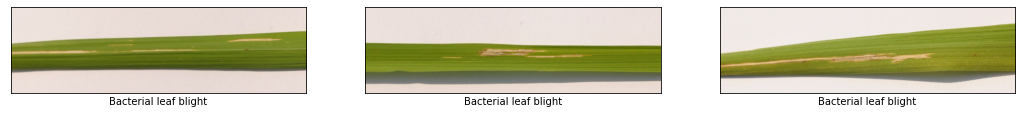

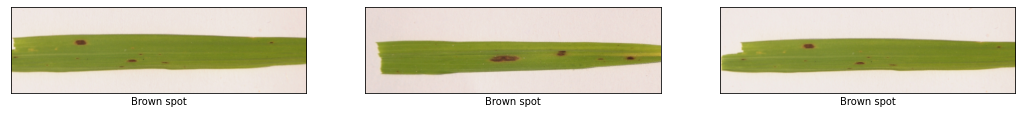

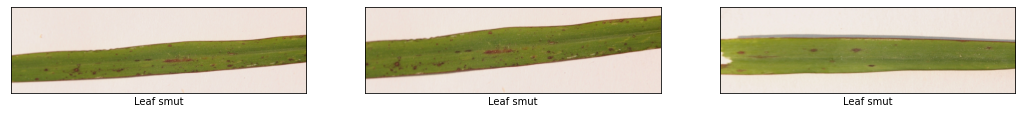

In [ ]:
# let's explore 3 files from each classes in the dataset

for names in class_names:
    path = os.path.join(DATADIR,names)
    img = list(os.listdir(path))
    plt.figure(figsize=(18,18))
    for i in range(3):
        filename = os.path.join(path,img[i])
        imag = image.load_img(filename)
        img_array = image.img_to_array(imag)
        plt.subplot(3,3,i+1)
        plt.xlabel(names)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_array/255)

plt.show()


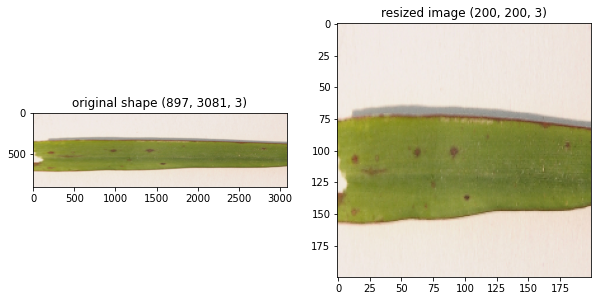

In [ ]:
# plotting one of the resized image alongside the original


resized_image = tf.image.resize(img_array, [200, 200])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_array/255)
plt.title('original shape {}'.format(img_array.shape))
plt.subplot(1,2,2)
plt.imshow(resized_image/255)
plt.title('resized image {}'.format(resized_image.shape))
plt.show()


In [ ]:
# create a dictionary for the number of images in each classes

number_classes = {'Bacterial_leaf_blight': len(os.listdir(os.path.join(DATADIR,class_names[0]))),
                  'Brown_spot': len(os.listdir(os.path.join(DATADIR,class_names[1]))),
                 'Leaf_smut': len(os.listdir(os.path.join(DATADIR,class_names[2])))} 



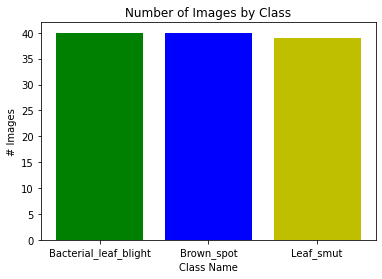

In [ ]:
plt.bar(number_classes.keys(), number_classes.values(),color=['g','b','y'])
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')
plt.show()

# Preprocessing the data


In [ ]:
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split=0.20
)

train_generator = datagen.flow_from_directory(
    DATADIR,
    classes=class_names,
    target_size=(200,200),
    batch_size=32,
    seed=100,
    subset='training',
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    DATADIR,
    classes=class_names,
    target_size=(200,200),
    seed=100,
    batch_size=8,
    subset='validation',
    class_mode='categorical'
)



Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


# Initialize the model and add layers

In [ ]:
model = Sequential()
# the shape of the data is (200,200,3) but use X.shape[1:] to get this value dynamically

model.add(Conv2D(16,kernel_size=(3, 3),input_shape=(200,200,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))  #pool_size the window size over which to take the maximum,

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))

model.add(Dense(3,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

## Compile

In [ ]:
class CustomCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs.get('val_accuracy')>=0.80:
            self.model.stop_training = True

stop_early = CustomCallBack()

In [ ]:

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer ='adam',
              metrics =['accuracy'])

history=model.fit(train_generator,
                  steps_per_epoch=3,
                  epochs=50,
                  validation_data=validation_generator,
                  validation_steps=3,
                  callbacks = [stop_early]
                 )

Epoch 1/50
3/3 [==============================] - 56s 8s/step - loss: 1.6153 - accuracy: 0.3229 - val_loss: 1.1041 - val_accuracy: 0.3478
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.0994 - accuracy: 0.3333 - val_loss: 1.1058 - val_accuracy: 0.3478
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 1.0755 - accuracy: 0.4271 - val_loss: 1.1537 - val_accuracy: 0.3043
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 1.0757 - accuracy: 0.3333 - val_loss: 1.1316 - val_accuracy: 0.4783
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 1.0252 - accuracy: 0.4062 - val_loss: 1.1514 - val_accuracy: 0.3913
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 0.9720 - accuracy: 0.6042 - val_loss: 1.2770 - val_accuracy: 0.3913
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 0.9178 - accuracy: 0.6354 - val_loss: 1.2530 - val_accuracy: 0.3913
Epoch 8/50
3/3 [========================

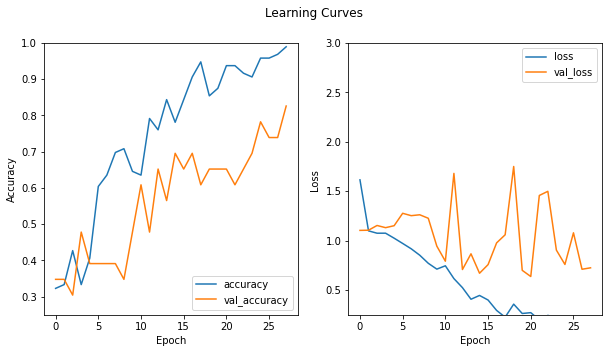

In [ ]:
# Evaluate the model

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.25,1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ')
plt.ylim([0.25,3])
plt.legend(loc='upper right')

plt.suptitle('Learning Curves')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator,verbose=2)

3/3 - 1s - loss: 0.7253 - accuracy: 0.8261


In [ ]:
x_test=np.array([])
y_test=np.array([])
for i in range(3):
  x_t,y_t=validation_generator.next()
  y_t=np.argmax(y_t,axis=1)
  x_test = np.append(x_test,x_t)
  y_test = np.append(y_test,y_t)
x_test = x_test.reshape(-1,200,200,3)


In [ ]:
y_test

array([2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 1., 2., 2., 1., 2., 1., 1.,
       0., 1., 0., 2., 2., 0.])

In [ ]:

loss ,acc = model.evaluate(x_test,to_categorical(y_test))

1/1 [==============================] - 0s 313ms/step - loss: 0.7253 - accuracy: 0.8261


In [ ]:
y_test,y_test.shape

(array([2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 1., 2., 2., 1., 2., 1., 1.,
        0., 1., 0., 2., 2., 0.]), (23,))

In [ ]:
x_test.shape

(23, 200, 200, 3)

In [ ]:
predictions=model.predict(x_test)
y_hat = np.argmax(predictions,axis=1)
predictions[20]

array([0.00408781, 0.06239998, 0.9335122 ], dtype=float32)

In [ ]:
pd.DataFrame((y_test,y_hat),index=['true','predicted'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
true,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0
predicted,2.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0


In [ ]:
y_test[16],y_hat[16]

(1.0, 1)

In [ ]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       0.75      0.75      0.75         8
         2.0       0.83      0.71      0.77         7

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.82      0.83      0.82        23



In [ ]:
model.save('flowfmdir.h5')

# Hyperparameter tuning with the Keras tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 6.4 MB/s 


In [ ]:
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.optimizers import Adam

In [ ]:
# Create a hyper model

def create_model(hp):
    model = Sequential()
    conv_1 = hp.Int('conv_1',min_value=16, max_value=512, step=16)
    conv_2 = hp.Int('conv_2',min_value=32, max_value=512, step=16)
    conv_3 = hp.Int('conv_3',min_value=32, max_value=512, step=16)
    
    model.add(Conv2D(filters=conv_1,kernel_size=3,activation='relu',input_shape =(200,200,3)))
    model.add(Conv2D(filters=conv_2,kernel_size=3,activation='relu'))
    model.add(Conv2D(filters=conv_3,kernel_size=3,activation='relu'))
    
    model.add(Flatten())

    model.add(Dense(3,activation='softmax'))
    
    l_r = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
    model.compile(optimizer= Adam(learning_rate=l_r),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner

tuner=RandomSearch(create_model,objective='val_accuracy',max_trials=5,seed = 1,directory='output',project_name="Rice_Leaf_ktrs1")



In [ ]:
# Create callback to stop training early
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min',restore_best_weights=True)

In [ ]:
tuner.search(train_generator,epochs=5,validation_data=validation_generator,callbacks = [early_stop])

Trial 5 Complete [00h 00m 49s]
val_accuracy: 0.3913043439388275

Best val_accuracy So Far: 0.6086956262588501
Total elapsed time: 00h 05m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in output/Rice_Leaf_ktrs1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1: 240
conv_2: 304
conv_3: 256
learning_rate: 0.001
Score: 0.6086956262588501
Trial summary
Hyperparameters:
conv_1: 144
conv_2: 80
conv_3: 496
learning_rate: 0.001
Score: 0.3913043439388275
Trial summary
Hyperparameters:
conv_1: 272
conv_2: 112
conv_3: 352
learning_rate: 0.0001
Score: 0.3913043439388275
Trial summary
Hyperparameters:
conv_1: 80
conv_2: 496
conv_3: 144
learning_rate: 0.01
Score: 0.3478260934352875
Trial summary
Hyperparameters:
conv_1: 320
conv_2: 416
conv_3: 192
learning_rate: 0.01
Score: 0.3478260934352875


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss_rs, accuracy_rs = best_model.evaluate(validation_generator)


3/3 [==============================] - 1s 214ms/step - loss: 1.6731 - accuracy: 0.6087


In [ ]:
los, accc = best_model.evaluate(x_test,to_categorical(y_test))

1/1 [==============================] - 5s 5s/step - loss: 1.6731 - accuracy: 0.6087


In [ ]:
tunerhp=Hyperband(create_model,objective='val_accuracy',max_epochs=5,seed = 1,directory='output',project_name="hyperband_flow1")

INFO:tensorflow:Reloading Oracle from existing project output/hyperband_flow1/oracle.json
INFO:tensorflow:Reloading Tuner from output/hyperband_flow1/tuner0.json


In [ ]:
tunerhp.search(train_generator,epochs=5,validation_data=validation_generator)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_1            |96                |144               
conv_2            |496               |80                
conv_3            |480               |496               
learning_rate     |0.0001            |0.001             
tuner/epochs      |5                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |0                 |1                 
tuner/round       |0                 |0                 

Epoch 1/5


ResourceExhaustedError: ignored

In [ ]:
tunerhp.results_summary()

Results summary
Results in output/hyperband_flow1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1: 144
conv_2: 80
conv_3: 496
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.43478259444236755
Trial summary
Hyperparameters:
conv_1: 240
conv_2: 304
conv_3: 256
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3913043439388275
Trial summary
Hyperparameters:
conv_1: 272
conv_2: 112
conv_3: 352
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3913043439388275
Trial summary
Hyperparameters:
conv_1: 80
conv_2: 496
conv_3: 144
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3478260934352875
Trial summary
Hyperparameters:
conv_1: 144
conv_2: 80
conv_3: 496
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket:

In [ ]:
best_modelhp=tunerhp.get_best_models(num_models=1)[0]

In [ ]:
loss_hp, accuracy_hp = best_modelhp.evaluate(validation_generator)

3/3 [==============================] - 1s 208ms/step - loss: 7.1522 - accuracy: 0.4348


In [ ]:
result=pd.DataFrame([[test_loss,test_acc],[loss_rs,accuracy_rs],[loss_hp,accuracy_hp]],columns=['Loss','Accuracy'],index=['Base Model','RandomSearch hp','HyperBand hp'])
result

,Loss,Accuracy
Base Model,0.725320,0.826087
RandomSearch hp,1.673077,0.608696
HyperBand hp,7.152159,0.434783


In [ ]:
if (test_acc > accuracy_rs):
  if (test_acc > accuracy_hp): final_model = model
  else: final_model = best_modelhp
elif (accuracy_rs >accuracy_hp):final_model = best_model
else:final_model = best_modelhp

final_model.evaluate(x_test,to_categorical(y_test))

1/1 [==============================] - 0s 26ms/step - loss: 0.7253 - accuracy: 0.8261


[0.7253199219703674, 0.8260869383811951]

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
